In [3]:
import pickle
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.layers import (Activation, Dense, Dropout, Flatten,Lambda, MaxPooling2D)
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, model_from_json
from keras.regularizers import l2
from keras.utils import np_utils
import matplotlib.image as mpimg
%pylab inline
from PIL import Image
from scipy.misc import toimage
#toimage(data).show()
import cv2
from scipy.misc import imshow
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers.merge import concatenate
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
#from spacialTransformer import SpatialTransformer
import csv
import glob,os

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [98]:
data=[]
labels=[]

In [99]:
for i in range(43):
    #path="‪..//Desktop//trafficsign//Train//{0}".format(i)
    curr=os.getcwd()
    path=os.path.join(curr,'Train\\{0}'.format(i))
    Class=os.listdir(path)
    for a in Class:
        image=cv2.imread(os.path.join(path,a))
        image_from_array=Image.fromarray(image,'RGB')
        size_image=image_from_array.resize((32,32))
        data.append(np.array(size_image))
        labels.append(i)
cells=np.array(data)
labels=np.array(labels)

In [2]:
#cells[0].shape
#labels.shape
cells=np.load('cells.npy')
labels=np.load('labels.npy')


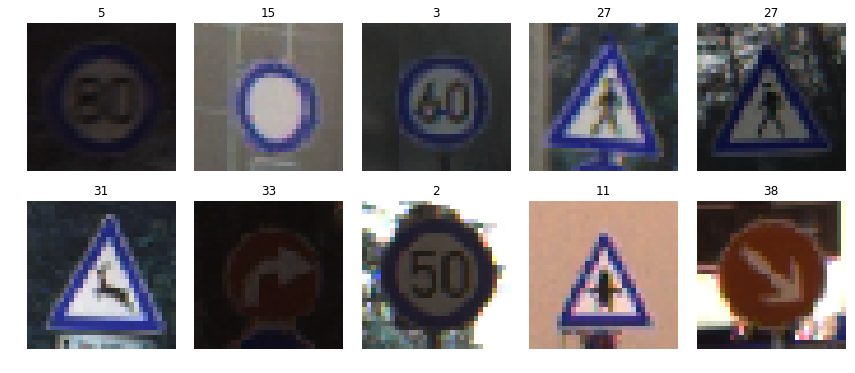

In [3]:
#img=mpimg.imread(cells[0])
import matplotlib.pyplot as plt
import random
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(cells))
    image = cells[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(labels[index])

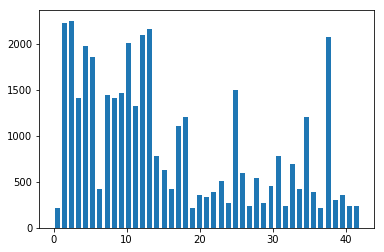

In [4]:
# histogram of label frequency
hist, bins = np.histogram(labels,bins=43)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [5]:
X_train=cells
y_train=labels

In [6]:
X_train_rgb = X_train
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)

#X_test_rgb = X_test
#X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

In [7]:
X_train_gry.shape
X_train=X_train_gry

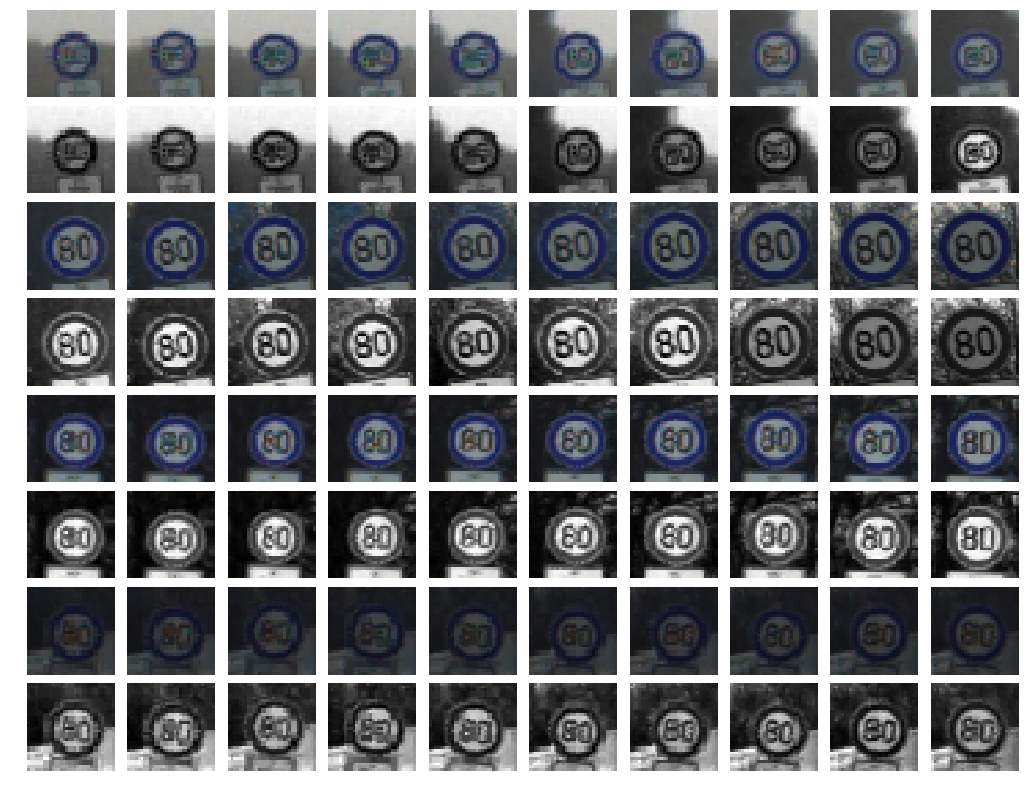

In [8]:
n_rows = 8
n_cols = 10
offset = 9000
fig, axs = plt.subplots(n_rows,n_cols, figsize=(18, 14))
fig.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()
for j in range(0,n_rows,2):
    for i in range(n_cols):
        index = i + j*n_cols
        image = X_train_rgb[index + offset]
        axs[index].axis('off')
        axs[index].imshow(image)
    for i in range(n_cols):
        index = i + j*n_cols + n_cols 
        image = X_train_gry[index + offset - n_cols].squeeze()
        axs[index].axis('off')
        axs[index].imshow(image, cmap='gray')

In [9]:
X_train_normalized = (X_train - 128)/128 

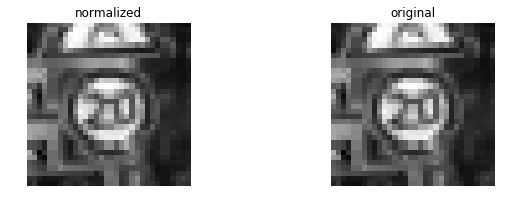

In [10]:
fig, axs = plt.subplots(1,2, figsize=(10, 3))
axs = axs.ravel()
axs[0].axis('off')
axs[0].set_title('normalized')
axs[0].imshow(X_train_normalized[0].squeeze(), cmap='gray')

axs[1].axis('off')
axs[1].set_title('original')
axs[1].imshow(X_train[0].squeeze(), cmap='gray')

shape in/out: (32, 32, 1) (32, 32, 1)


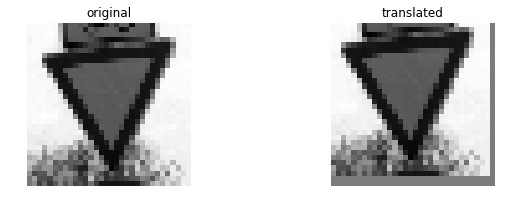

In [11]:
def random_translate(img):
    rows,cols,_ = img.shape
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)
    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    dst = dst[:,:,np.newaxis]
    return dst

test_img = X_train_normalized[22222]
test_dst = random_translate(test_img)
fig, axs = plt.subplots(1,2, figsize=(10, 3))
axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')
axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('translated')
print('shape in/out:', test_img.shape, test_dst.shape)

shape in/out: (32, 32, 1) (32, 32, 1)


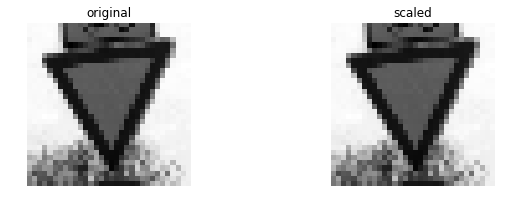

In [12]:
def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_scaling(test_img)
    
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('scaled')

print('shape in/out:', test_img.shape, test_dst.shape)

shape in/out: (32, 32, 1) (32, 32, 1)


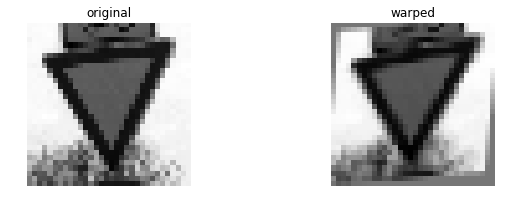

In [13]:

def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_warp(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('warped')

print('shape in/out:', test_img.shape, test_dst.shape)

shape in/out: (32, 32, 1) (32, 32, 1)


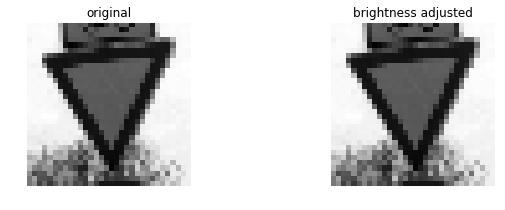

In [14]:
def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

test_dst = random_brightness(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('brightness adjusted')

print('shape in/out:', test_img.shape, test_dst.shape)

In [15]:
class_indices = np.where(y_train == 0)
len(class_indices[0])
class_indices=list(class_indices[0])
#class_indices
#X_train_normalized.shape

In [16]:
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

input_indices = []
output_indices = []

for class_n in range(43):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train_normalized.shape[0])
            new_img = X_train_normalized[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_train_normalized = np.concatenate((X_train_normalized, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

X, y shapes: (39209, 32, 32, 1) (39209,)
0 : |----|----|----|----|----|----|----|----|----|----|----|---
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|----|----|----|----|--
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : |-
15 : |----|----|----|-
16 : |----|----|----|----|----|----|----|--
17 : 
18 : 
19 : |----|----|----|----|----|----|----|----|----|----|----|---
20 : |----|----|----|----|----|----|----|----|---
21 : |----|----|----|----|----|----|----|----|----|-
22 : |----|----|----|----|----|----|----|----|
23 : |----|----|----|----|----|---
24 : |----|----|----|----|----|----|----|----|----|----|--
25 : 
26 : |----|----|----|----
27 : |----|----|----|----|----|----|----|----|----|----|----|
28 : |----|----|----|----|----|
29 : |----|----|----|----|----|----|----|----|----|----|--
30 : |----|----|----|----|----|----|----
31 : |-
32 : |----|----|----|----|----|----|----|----|----|----|----|
33 : |----|----|-
34 : |----|----|----|----|----|----|----|--
35 : 
36 : |----|----|----|----|--

In [18]:
X_train_normalized.shape
#y_train.shape

(49510, 32, 32, 1)

In [19]:
#np.save('x_train',X_train_normalized)
#np.save('y_train',y_train)

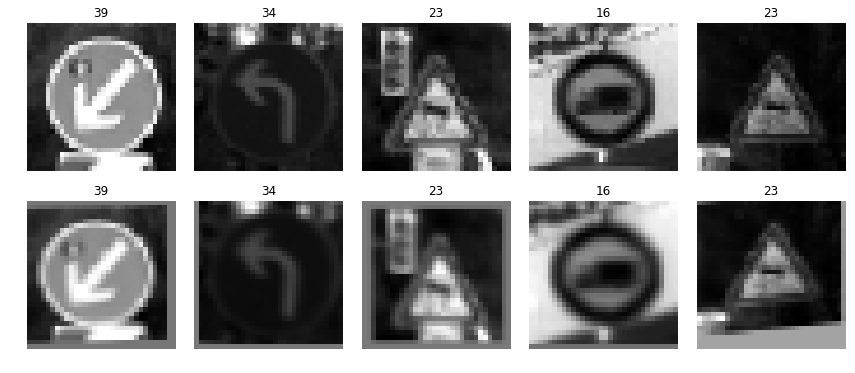

In [150]:
choices = list(range(len(input_indices)))
picks = []
for i in range(5):
    rnd_index = np.random.randint(low=0,high=len(choices))
    picks.append(choices.pop(rnd_index))
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(5):
    image = X_train_normalized[input_indices[picks[i]]].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image, cmap = 'gray')
    axs[i].set_title(y_train[input_indices[picks[i]]])
for i in range(5):
    image = X_train_normalized[output_indices[picks[i]]].squeeze()
    axs[i+5].axis('off')
    axs[i+5].imshow(image, cmap = 'gray')
    axs[i+5].set_title(y_train[output_indices[picks[i]]])

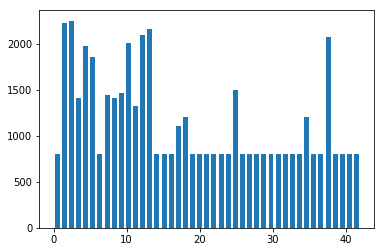

In [152]:
hist, bins = np.histogram(y_train, bins=43)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [25]:
IMG_SIZE=32
NUM_CLASSES=43
#X_train_normalized.shape

In [175]:
#np.save('x_train',X_train_normalized)
#np.save('y_train',y_train)
#np.save('cells',cells)
#np.save('labels',labels)

In [3]:
#X_train_normalized=np.load('x_train.npy')
#y_train=np.load('y_train.npy')

In [7]:
#X_train_normalized.shape

(39608, 43, 43)

In [20]:
from sklearn.utils import shuffle
X_train_normalized, y_train = shuffle(X_train_normalized, y_train)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train_normalized, y_train, 
                                                                test_size=0.20, random_state=42)

In [22]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,43)
y_validation=to_categorical(y_validation,43)

In [26]:
def lenet_2():
    inputs = Input(shape=(32,32,1))
    conv1=Conv2D(6, (5, 5), padding='valid',
                     input_shape=(IMG_SIZE, IMG_SIZE,1),
                     activation='relu')(inputs)
    pool1=MaxPooling2D(pool_size=(2, 2),padding='valid')(conv1)
    conv2=Conv2D(16, (5, 5), padding='valid',activation='relu')(pool1)
    pool2=MaxPooling2D(pool_size=(2, 2),padding='valid')(conv2)
    conv3=Conv2D(400, (5, 5), padding='valid',activation='relu')(pool2)
    layer2flat=Flatten()(pool2)
    xflat=Flatten()(conv3)
    merge=concatenate([xflat,layer2flat])
    hid1=Dropout(0.5)(merge)
    final=Dense(NUM_CLASSES, activation='softmax')(hid1)
    model=Model(inputs=inputs,outputs=final)
    return model

In [27]:
model=lenet_2()

In [28]:
lr = 0.01
#model=cnn_model()
#sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 6)    156         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 6)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 10, 10, 16)   2416        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [34]:
#epochs=1
model.fit(X_train,y_train,batch_size=32,epochs=60,validation_data=(X_validation,y_validation))

Train on 39608 samples, validate on 9902 samples
Epoch 1/60
39608/39608 [==============================] - 21s 525us/step - loss: 0.2506 - acc: 0.9249 - val_loss: 0.1474 - val_acc: 0.9596
Epoch 2/60
39608/39608 [==============================] - 24s 604us/step - loss: 0.1838 - acc: 0.9448 - val_loss: 0.1145 - val_acc: 0.9659
Epoch 3/60
39608/39608 [==============================] - 25s 627us/step - loss: 0.1520 - acc: 0.9523 - val_loss: 0.1098 - val_acc: 0.9686
Epoch 4/60
39608/39608 [==============================] - 27s 673us/step - loss: 0.1245 - acc: 0.9615 - val_loss: 0.1050 - val_acc: 0.9672
Epoch 5/60
39608/39608 [==============================] - 26s 653us/step - loss: 0.1044 - acc: 0.9672 - val_loss: 0.0815 - val_acc: 0.9775
Epoch 6/60
39608/39608 [==============================] - 27s 677us/step - loss: 0.0963 - acc: 0.9698 - val_loss: 0.0810 - val_acc: 0.9758
Epoch 7/60
39608/39608 [==============================] - 25s 625us/step - loss: 0.0868 - acc: 0.9717 - val_loss: 0.0

In [35]:
from keras.models import load_model
#model.save('model1.h5')
#model=load_model('model1.h5')

In [39]:
y_prob = model.predict(X_validation) 
y_classes = y_prob.argmax(axis=-1)

In [41]:
X_validation.shape

(9902, 32, 32, 1)

In [46]:
from keras.preprocessing import image
test_image = image.load_img(r'C:\Users\ANSHUL\Desktop\trafficsign\Train\7\00007_00000_00000.png', target_size = (32,32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
test_image= np.sum(test_image/3, axis=3, keepdims=True)
test_image = (test_image - 128)/128 
result =model.predict(test_image)
ans= result.argmax(axis=-1)
print(ans)

[7]


In [44]:
import pandas as pd
y_test=pd.read_csv("Test.csv")

array([[0.0000000e+00, 8.3246350e-33, 5.8295464e-23, 1.2104433e-30,
        9.7072193e-36, 7.9344806e-20, 0.0000000e+00, 1.1076383e-15,
        2.9160780e-31, 1.1550894e-20, 1.0000000e+00, 5.4947906e-22,
        2.7581782e-26, 1.6882742e-33, 0.0000000e+00, 2.7979262e-35,
        3.0964543e-28, 2.0728570e-37, 5.9467239e-38, 3.2602832e-34,
        2.6301658e-26, 2.5300729e-25, 0.0000000e+00, 9.2020445e-29,
        2.0180534e-37, 1.5838751e-20, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.9206362e-35, 3.5971916e-26, 2.4671622e-30,
        0.0000000e+00, 2.1902393e-32, 4.5046235e-37, 5.8851406e-37,
        0.0000000e+00, 2.0529884e-28, 3.3736853e-33, 9.5931660e-38,
        2.3256291e-22, 8.0643381e-38, 5.2954529e-20]], dtype=float32)

In [ ]:
labels=np.asarray(y_test['Path'])
y_test=y_test['ClassId'].values
data=[]
for f in labels:
    image=cv2.imread(f)
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((32,32))
    data.append(np.array(size_image))

#X_test=np.array(data)
#X_test = X_test.astype('float32')/255 
#pred = model.predict_classes(X_test)
data=np.array(data)
y_test=np.array(y_test)

In [ ]:
y_test=y_test['ClassId'].values
y_test=np.array(y_test)
X_test=data
X_test= np.sum(X_test/3, axis=3, keepdims=True)
X_test =(X_test - 128)/128 
from keras.utils import to_categorical
#y_test=to_categorical(y_test,43)
result=model.predict(X_test)
ans= result.argmax(axis=-1)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,ans)

In [ ]:
c=0
for i in range(12630):
    if ans[i]!=y_test[i]:
        c+=1
c

In [37]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#train_datagen=ImageDataGenerator()
training_set = train_datagen.flow_from_directory(r'C:\Users\ANSHUL\Desktop\trafficsign\Train',
                                                 target_size = (32,32),color_mode="grayscale",
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 39209 images belonging to 43 classes.


In [13]:
#batch=training_set.next()
#r=np.asarray(training_set[4][0][0])

In [38]:
NUM_CLASSES = 43
IMG_SIZE = 32

In [39]:
#X_train_rgb = X_train
#X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)

In [40]:
training_set[0][0].shape

(32, 32, 32, 1)

In [17]:
#x= np.sum(np.asarray(training_set[0][0])/3, axis=3, keepdims=True)

In [44]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(6, (5, 5), padding='valid',
                     input_shape=(IMG_SIZE, IMG_SIZE,1),
                     activation='relu'))
    #model.add(Conv2D(6, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    #model.add(Dropout(0.2))

    model.add(Conv2D(16, (5, 5), padding='valid',
                     activation='relu'))
    #model.add(Conv2D(16, (5, 6), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    #model.add(Dropout(0.2))

    #model.add(Conv2D(128, (3, 3), padding='same',
    #                 activation='relu'))
    #model.add(Conv2D(128, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(84, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [47]:
model1=cnn_model

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               48120     
_________________________________________________________________
dropout_9 (Dropout)          (None, 120)               0         
__________

In [45]:
lr = 0.01
model=cnn_model()
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [98]:
def lenet_2():
    inputs = Input(shape=(32,32,1))
    conv1=Conv2D(6, (5, 5), padding='valid',
                     input_shape=(IMG_SIZE, IMG_SIZE,1),
                     activation='relu')(inputs)
    pool1=MaxPooling2D(pool_size=(2, 2),padding='valid')(conv1)
    conv2=Conv2D(16, (5, 5), padding='valid',activation='relu')(pool1)
    pool2=MaxPooling2D(pool_size=(2, 2),padding='valid')(conv2)
    conv3=Conv2D(400, (5, 5), padding='valid',activation='relu')(pool2)
    layer2flat=Flatten()(pool2)
    xflat=Flatten()(conv3)
    merge=concatenate([xflat,layer2flat])
    hid1=Dropout(0.5)(merge)
    final=Dense(NUM_CLASSES, activation='softmax')(hid1)
    model=Model(inputs=inputs,outputs=final)
    return model

In [99]:
model=lenet_2()

In [100]:
lr = 0.01
#model=cnn_model()
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [48]:
#model.fit_generator(training_set,steps_per_epoch=39209/32,epochs=10)

In [101]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 28, 28, 6)    156         input_20[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_46 (MaxPooling2D) (None, 14, 14, 6)    0           conv2d_76[0][0]                  
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 10, 10, 16)   2416        max_pooling2d_46[0][0]           
__________________________________________________________________________________________________
max_poolin

In [103]:
#model.fit_generator(training_set,steps_per_epoch=39209/32,epochs=5)